In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.losses import CategoricalCrossentropy

from Environment.Intersection import Lane, Approach, Intersection, Exit, Trafficlight, TrafficLightGroup

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

tf.get_logger().setLevel('ERROR')

# Load model

In [2]:
# Exit N
exit_n_r = Lane([0], None, True, None)
exit_n = Exit(0, [exit_n_r])

# Exit E
exit_e_r = Lane([0], None, True, None)
exit_e_l = Lane([0], None, True, None)
exit_e = Exit(1, [exit_e_r, exit_e_l])

# Exit S
exit_s_r = Lane([0], None, True, None)
exit_s = Exit(2, [exit_s_r])

# Exit W
exit_w_r = Lane([0], None, True, None)
exit_w_l = Lane([0], None, True, None)
exit_w = Exit(3, [exit_w_r, exit_w_l])

# Approach N
traffic_light_n_r = Trafficlight(0, [1], 0, 1, 2)
traffic_light_n_l = Trafficlight(1, [0, 2], 0, 1, 2)

lane_n_r = Lane([1], traffic_light_n_r, False, [exit_w_r])
lane_n_l = Lane([0, 2], traffic_light_n_l, False, [exit_s_r, exit_e_l])

approach_n = Approach(0, [lane_n_r, lane_n_l], 90)

# Approach E
traffic_light_e_r = Trafficlight(2, [0, 1], 0, 1, 2)
traffic_light_e_m = Trafficlight(3, [0], 0, 1, 2)
traffic_light_e_l = Trafficlight(4, [2], 0, 1, 2)

lane_e_r = Lane([0, 1], traffic_light_e_r, False, [exit_n_r, exit_w_r])
lane_e_m = Lane([0], traffic_light_e_m, False, [exit_w_l])
lane_e_l = Lane([2], traffic_light_e_l, False, [exit_s_r])

approach_e = Approach(1, [lane_e_r, lane_e_m, lane_e_l], 0)

# Approach S
traffic_light_s_r = Trafficlight(5, [0, 1], 0, 1, 2)
traffic_light_s_l = Trafficlight(6, [2], 0, 1, 2)

lane_s_r = Lane([0, 1], traffic_light_s_r, False, [exit_e_r, exit_n_r])
lane_s_l = Lane([2], traffic_light_s_l, False, [exit_w_l])

approach_s = Approach(2, [lane_s_r, lane_s_l], 270)

# Approach W
traffic_light_w_r = Trafficlight(7, [0, 1], 0, 1, 2)
traffic_light_w_m = Trafficlight(8, [0], 0, 1, 2)
traffic_light_w_l = Trafficlight(9, [2], 0, 1, 2)

lane_w_r = Lane([0, 1], traffic_light_w_r, False, [exit_s_r, exit_e_r])
lane_w_m = Lane([0], traffic_light_w_m, False, [exit_e_l])
lane_w_l = Lane([2], traffic_light_w_l, False, [exit_n_r])

approach_w = Approach(3, [lane_w_r, lane_w_m, lane_w_l], 180)

traffic_light_group_ns_s = TrafficLightGroup([traffic_light_n_r, traffic_light_n_l, traffic_light_s_r, traffic_light_s_l])
traffic_light_group_ew_s = TrafficLightGroup([traffic_light_e_r, traffic_light_e_m, traffic_light_w_r, traffic_light_w_m])
traffic_light_group_ew_l = TrafficLightGroup([traffic_light_e_l, traffic_light_w_l])

u = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
i = [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3]
V = [[1, 1, 0, 0, 0, 1, 1, 0, 0, 0],
     [0, 0, 1, 1, 0, 0, 0, 1, 1, 0],
     [0, 0, 0, 0, 1, 0, 0, 0, 0, 1]]
e_max = 15

# Intersection
intersection = Intersection([approach_n, approach_e, approach_s, approach_w], [exit_n, exit_e, exit_s, exit_w], [traffic_light_group_ns_s, traffic_light_group_ew_s, traffic_light_group_ew_l], u, i, V, e_max)
# intersection.render()
intersection.generate_random_traffic(50)
# print(intersection.step([2, 3, 4]))

# Random

In [3]:
# intersection.generate_traffic(100)

# action_space = [0, 1, 2]

# for x in range(500):
#     print(intersection.step(np.random.choice(action_space)))
    
# reward_history = intersection.close()

In [4]:
# # Plot the reward over time
# plt.plot(reward_history)

# Policy Gradient

In [5]:
class PolicyGradientAgent:
  def __init__(self, env, path=None):
    self.env=env 
    self.state_shape= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    self.action_shape= 3
    self.gamma=0.99
    self.alpha=1e-4
    self.learning_rate=0.01

    self.states=[]
    self.gradients=[] 
    self.rewards=[]
    self.probs=[]
    self.discounted_rewards=[]
    self.total_rewards=[]
    
    self._output_rewards = []
    
    if not path:
      self.model=self.build_policy_network()
    else:
      self.model=self.load_model(path)

  def build_policy_network(self):
    model=Sequential()
    model.add(Dense(24, input_shape=self.state_shape, activation="relu"))
    model.add(Dense(12, activation="relu"))
    model.add(Dense(self.action_shape, activation="softmax")) 
    model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=self.learning_rate))
    return model

  def hot_encode_action(self, action):
    action_encoded=np.zeros(self.action_shape)
    action_encoded[action]=1
    return action_encoded
  
  def remember(self, state, action, action_prob, reward):
    encoded_action=self.hot_encode_action(action)
    self.gradients.append(encoded_action-action_prob)
    self.states.append(state)
    self.rewards.append(reward)
    self.probs.append(action_prob)

  def compute_action(self, state):
    state=state.reshape([1, state.shape[0]])
    # print(state)
    action_probability_distribution=self.model.predict(state).flatten()
    action_probability_distribution/=np.sum(action_probability_distribution)
    action=np.random.choice([0, 1, 2]) #!
    return action, action_probability_distribution

  def get_discounted_rewards(self, rewards): 
    discounted_rewards=[]
    cumulative_total_return=0

    for reward in rewards[::-1]:      
      cumulative_total_return=(cumulative_total_return*self.gamma)+reward
      discounted_rewards.insert(0, cumulative_total_return)

    mean_rewards=np.mean(discounted_rewards)
    std_rewards=np.std(discounted_rewards)
    norm_discounted_rewards=(discounted_rewards-mean_rewards)/(std_rewards+1e-7)
    return norm_discounted_rewards

  def train_policy_network(self):
    states=np.vstack(self.states)
    gradients=np.vstack(self.gradients)
    rewards=np.vstack(self.rewards)
    discounted_rewards=self.get_discounted_rewards(rewards)
    gradients*=discounted_rewards
    y_train = self.alpha*np.vstack([gradients])+self.probs
    history=self.model.train_on_batch(states, y_train)
    
    self.states, self.probs, self.gradients, self.rewards=[], [], [], []
    return history

  def train(self, episodes):
    env=self.env
    total_rewards=np.zeros(episodes)

    for episode in range(episodes):
      state=env.reset()
      done=False          
      episode_reward=0
      
      while not done:
        action, prob=self.compute_action(state)
        next_state, reward, done, _=env.step(action)
        self.remember(state, action, prob, reward)
        state=next_state
        episode_reward+=reward

        # env.render()
        if done:
            history=self.train_policy_network()

      total_rewards[episode]=episode_reward
      print('Episode = ',episode, 'Reward = ',episode_reward)
      self._output_rewards.append(episode_reward)

    self.total_rewards=total_rewards

  def hot_encode_action(self, action):
    action_encoded=np.zeros(self.action_shape)
    action_encoded[action]=1
    return action_encoded
  
  def remember(self, state, action, action_prob, reward):
    encoded_action=self.hot_encode_action(action)
    self.gradients.append(encoded_action-action_prob)
    self.states.append(state)
    self.rewards.append(reward)
    self.probs.append(action_prob)

  @property
  def output_rewards(self):
        return self._output_rewards

In [6]:
Agent = PolicyGradientAgent(intersection)
Agent.train(500)

rewards = Agent.output_rewards
plt.plot(rewards)
plt.show()

c:\Users\arthu\.conda\envs\ResearchProject\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


IndexError: index 0 is out of bounds for axis 0 with size 0

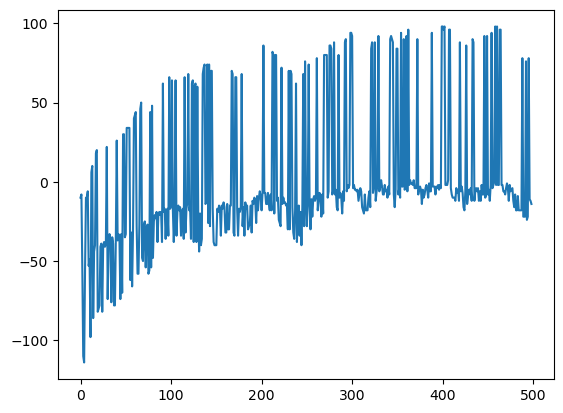

In [7]:
plt.plot(rewards[1:])
plt.show()